In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train_data = pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (1460, 81)
Test shape: (1459, 80)


EDA ANALYSIS

Checking for Missing Values

In [3]:
for col in train_data.columns:
    if col not in test_data.columns:
        continue  # skip target column or any column missing from test
    if train_data[col].dtype == 'object':
        train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
        test_data[col] = test_data[col].fillna(test_data[col].mode()[0])
    else:
        train_data[col] = train_data[col].fillna(train_data[col].median())
        test_data[col] = test_data[col].fillna(test_data[col].median())


In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,12,2008,WD,Normal,250000


In [5]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
test_data = test_data.fillna(0)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [7]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Grvl,Reg,Lvl,AllPub,...,120,0,Ex,MnPrv,Shed,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,Grvl,IR1,Lvl,AllPub,...,0,0,Ex,MnPrv,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,Grvl,IR1,Lvl,AllPub,...,0,0,Ex,MnPrv,Shed,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,Grvl,IR1,Lvl,AllPub,...,0,0,Ex,MnPrv,Shed,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,Grvl,IR1,HLS,AllPub,...,144,0,Ex,MnPrv,Shed,0,1,2010,WD,Normal


In [8]:
columns = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Utilities', 'Street']
train_data = train_data.drop(columns=columns, axis=1, errors='ignore')
test_data = test_data.drop(columns=columns, axis=1, errors='ignore')

In [9]:
train_data.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 73, dtype: int64

In [10]:
test_data.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 72, dtype: int64

/tmp/ipykernel_18/2158008212.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'], color='b', bins=100,
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Density'>

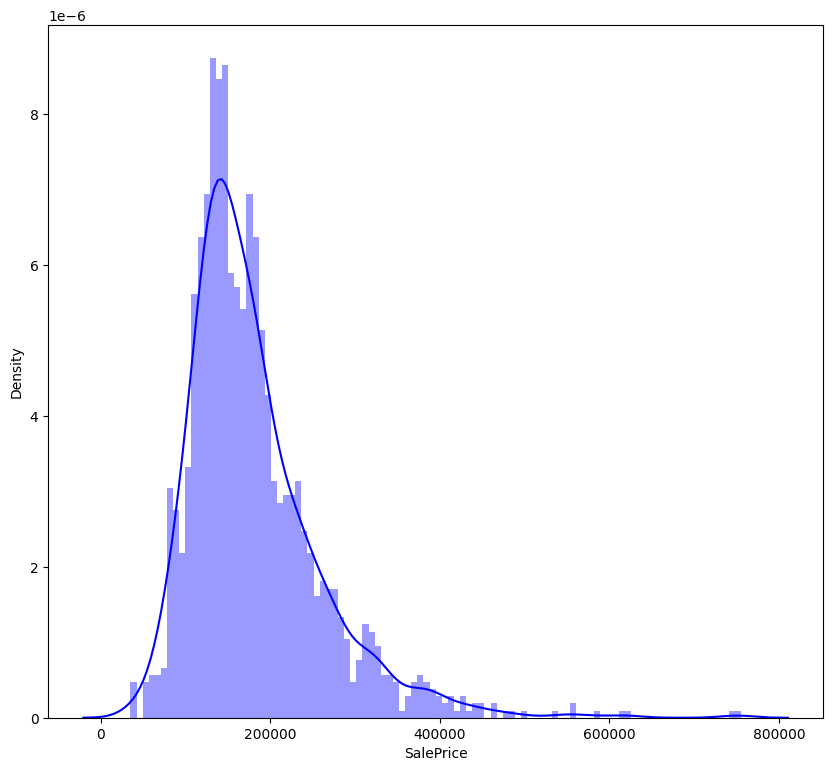

In [11]:
plt.figure(figsize=(10,9))
sns.distplot(train_data['SalePrice'], color='b', bins=100, 
             hist_kws={'alpha' : 0.4})

In [12]:
# Combine train and test for consistent label encoding
all_data = pd.concat([train_data, test_data], axis=0)

for col in all_data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col])

# Split back to train and test
train_data = all_data.iloc[:len(train_data), :]
test_data = all_data.iloc[len(train_data):, :]


In [13]:
# Log transform the target variable to reduce skewness
train_data.loc[:, 'SalePrice'] = np.log1p(train_data['SalePrice'])

In [14]:
X = train_data.drop(columns='SalePrice')
y = train_data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (1168, 72), Test set: (292, 72)


In [15]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()

In [16]:
# Making predictions on the same data
y_pred = rf.predict(X_test)
 
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rms = sqrt(mse)
print(f'Root Mean Squared Error: {rms}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 0.021432733528342594
Root Mean Squared Error: 0.14639922652918147
R-squared: 0.8851475270004416


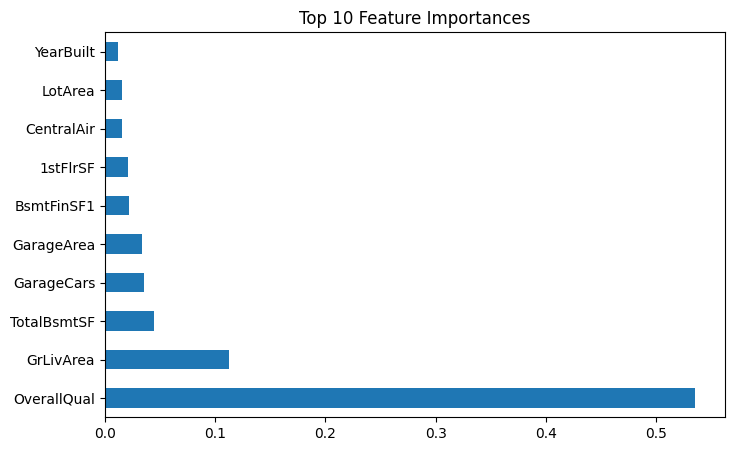

In [17]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
importances.plot(kind='barh', figsize=(8,5), title='Top 10 Feature Importances')
plt.show()


In [18]:
final_pred = np.expm1(rf.predict(test_data.drop(columns='SalePrice', errors='ignore')))
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': final_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")


Submission file saved as submission.csv
